## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import config
import massbalancemachine as mbm
from collections import defaultdict

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)
free_up_cuda()
custom_working_dir = '../../../data/OGGM/'

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_winter = '#a6cee3'
color_annual = '#1f78b4'

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

# Specify the short names of the climate variables available in the dataset
# vois_climate = [
#     't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
# ]

vois_climate = [
    't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

## Read GL data:

In [4]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if gl == 'claridenU':
        glacierCap[gl] = 'Clariden_U'
    elif gl == 'claridenL':
        glacierCap[gl] = 'Clariden_L'
    else:
        glacierCap[gl] = gl.capitalize()

data_glamos.head(2)

Number of glaciers: 32


YEAR  POINT_ID GLACIER  FROM_DATE   TO_DATE  POINT_LAT  POINT_LON  \
0  2006  adler_28   adler   20051017  20061011  46.010637   7.855896   
1  2006  adler_55   adler   20051017  20061011  46.010052   7.858628   

   POINT_ELEVATION  POINT_BALANCE  PERIOD           RGIId      aspect  \
0      3096.507742         -2.592  annual  RGI60-11.02764  254.483669   
1      3141.506520         -2.502  annual  RGI60-11.02764  273.466595   

       slope    topo  hugonnet_dhdt  consensus_ice_thickness  millan_v  \
0  19.483581  3039.0      -1.504815                43.181839  3.591626   
1  12.549861  3091.0      -0.970061                41.090096  0.975349   

   aspect_sgi  slope_sgi     topo_sgi  
0  286.843880  20.604390  3018.033333  
1  258.181463  12.582387  3077.711111

In [5]:
data_glamos.columns

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

### All glaciers:

Text(0.5, 1.0, 'Number of total measurements per glacier since 1951')

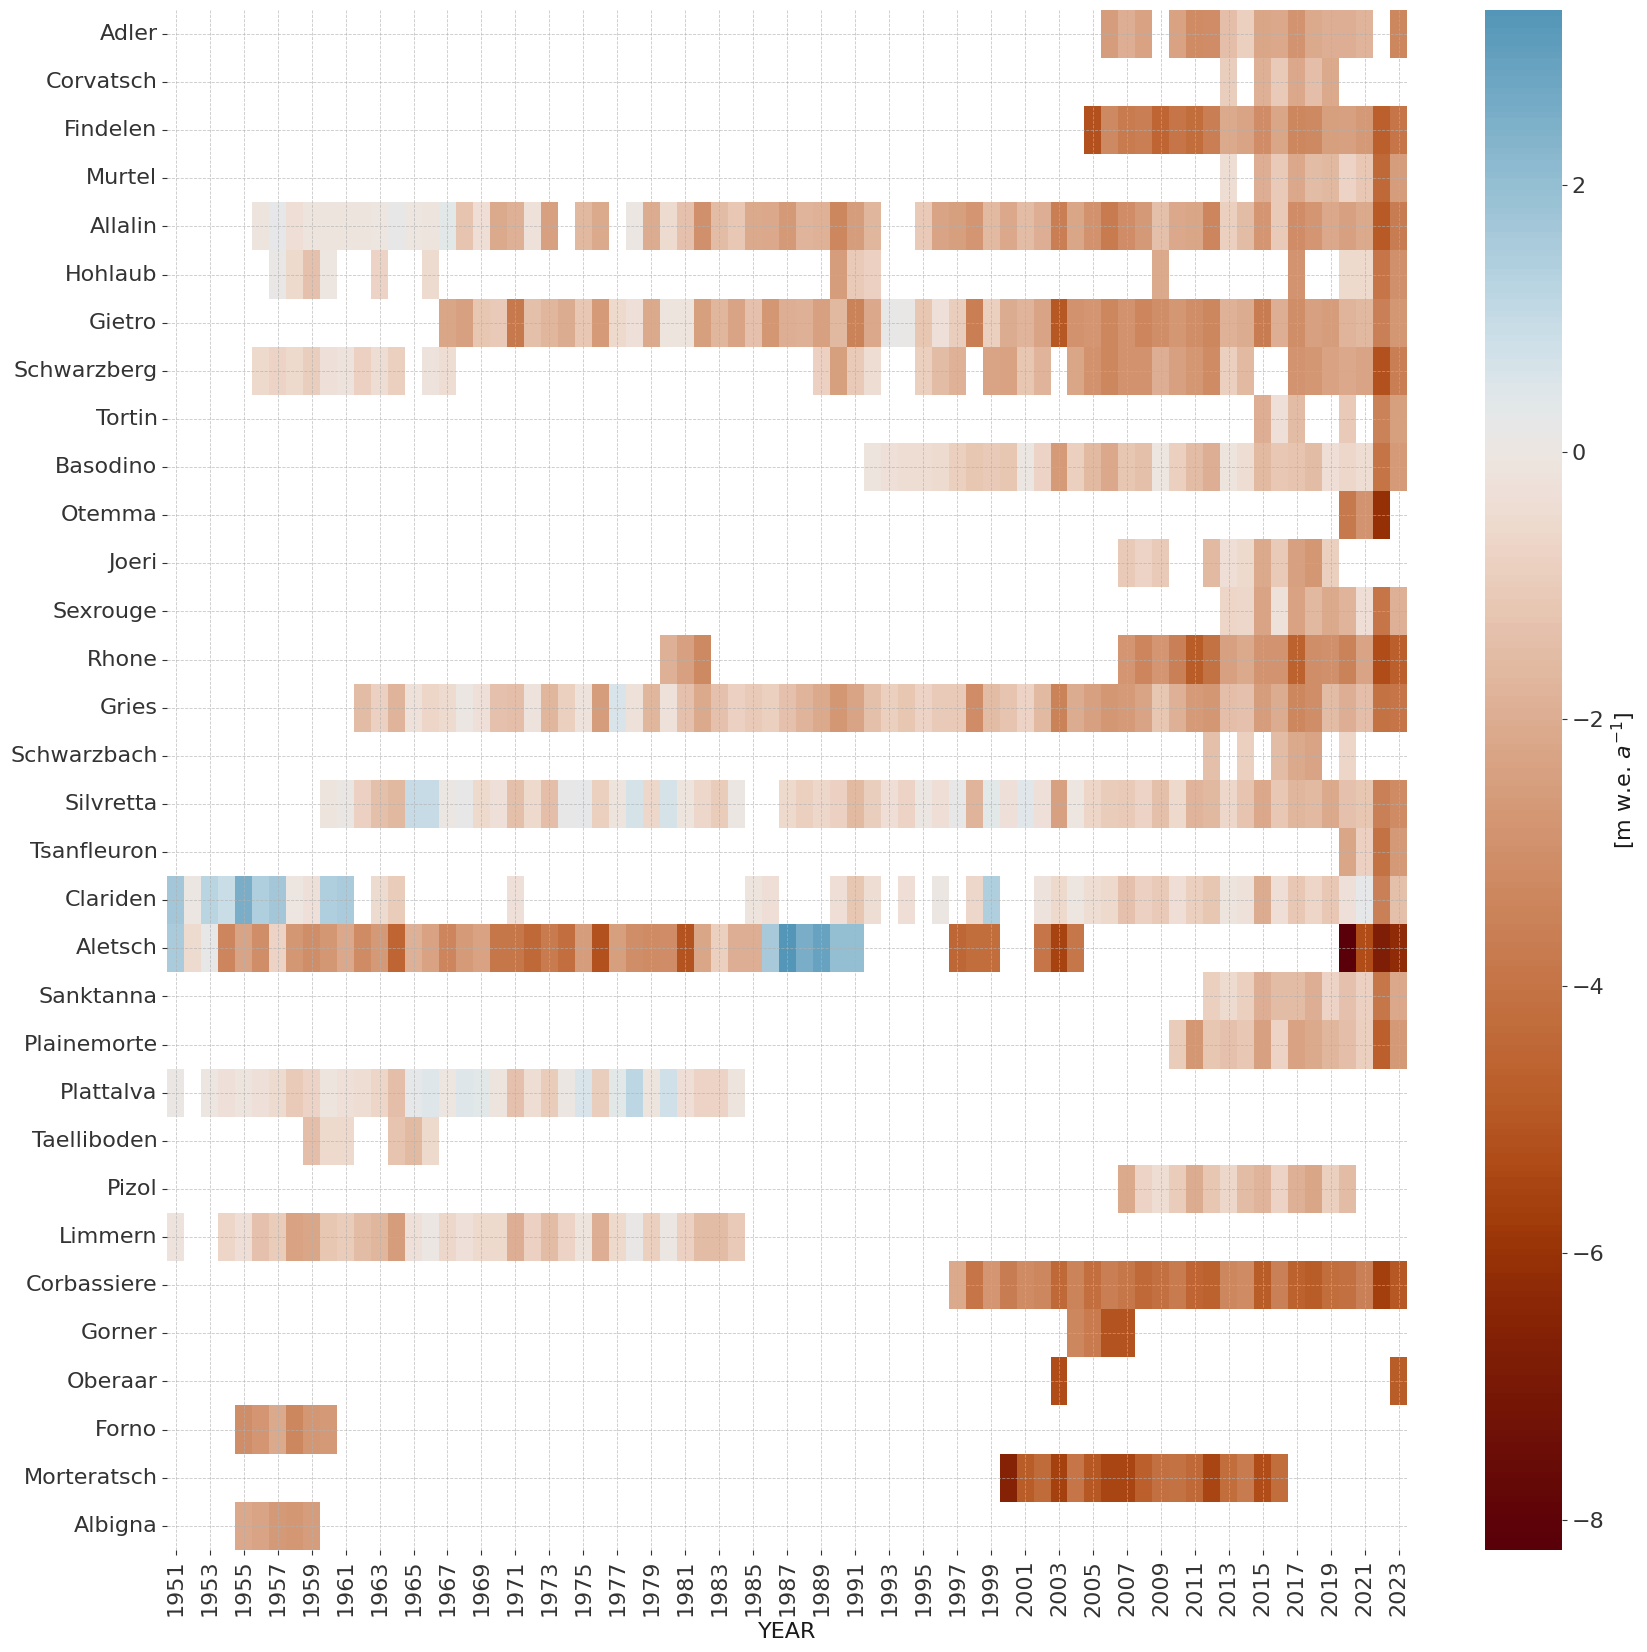

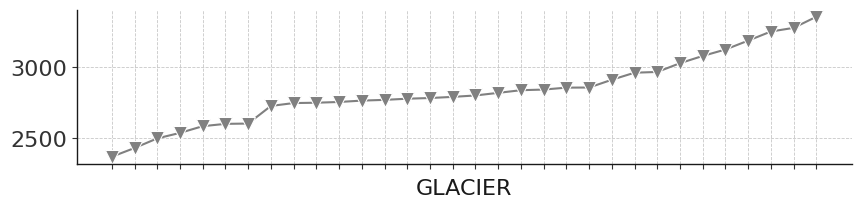

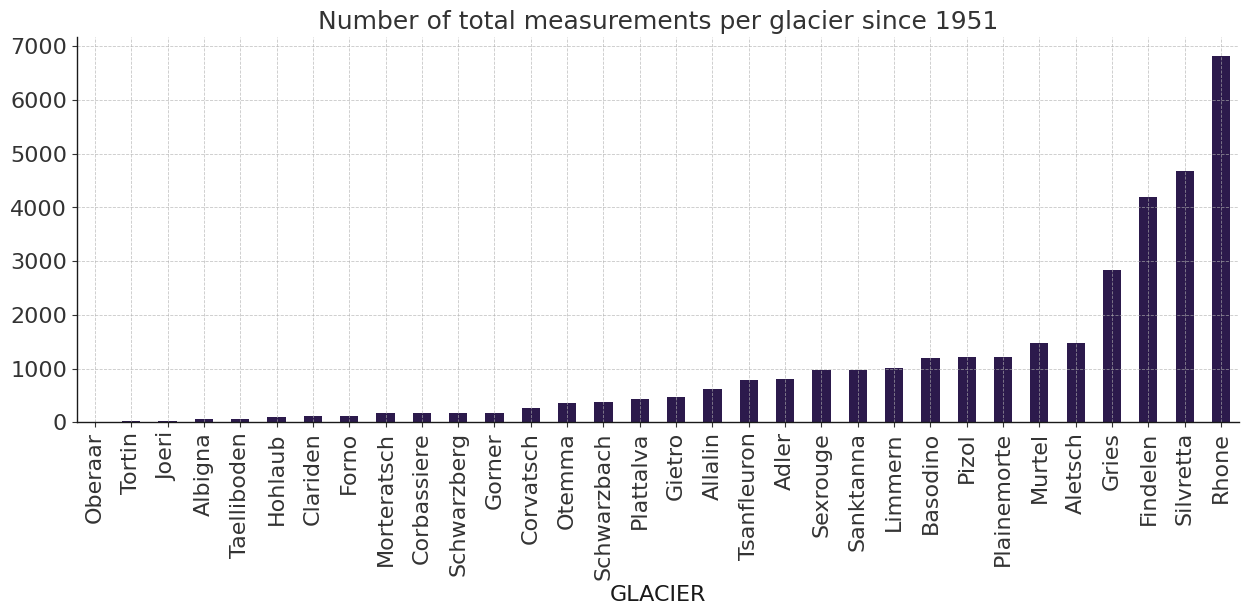

In [6]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos.GLACIER.apply(lambda x: glacierCap[x])
mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)
matrix = matrix.loc[gl_per_el.index]

# make index categorical
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=matrix,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')

fig = plt.figure(figsize=(10, 2))
num_gl = data_glamos_.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5), cmap=cm.devon)
plt.title('Number of total measurements per glacier since 1951')


### Glaciers with pot. radiadation data:

In [7]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

restgl = Diff(list(glDirect), list(data_glamos.GLACIER.unique()))
restgl.sort()
print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

Glaciers with potential clear sky radiation data:
 ['adler', 'albigna', 'aletsch', 'allalin', 'arolla', 'basodino', 'clariden', 'corbassiere', 'corvatsch', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma', 'pers', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta', 'taelliboden', 'tortin', 'tsanfleuron']
Number of glaciers: 34
Glaciers without potential clear sky radiation data:
 ['arolla', 'pers']


<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

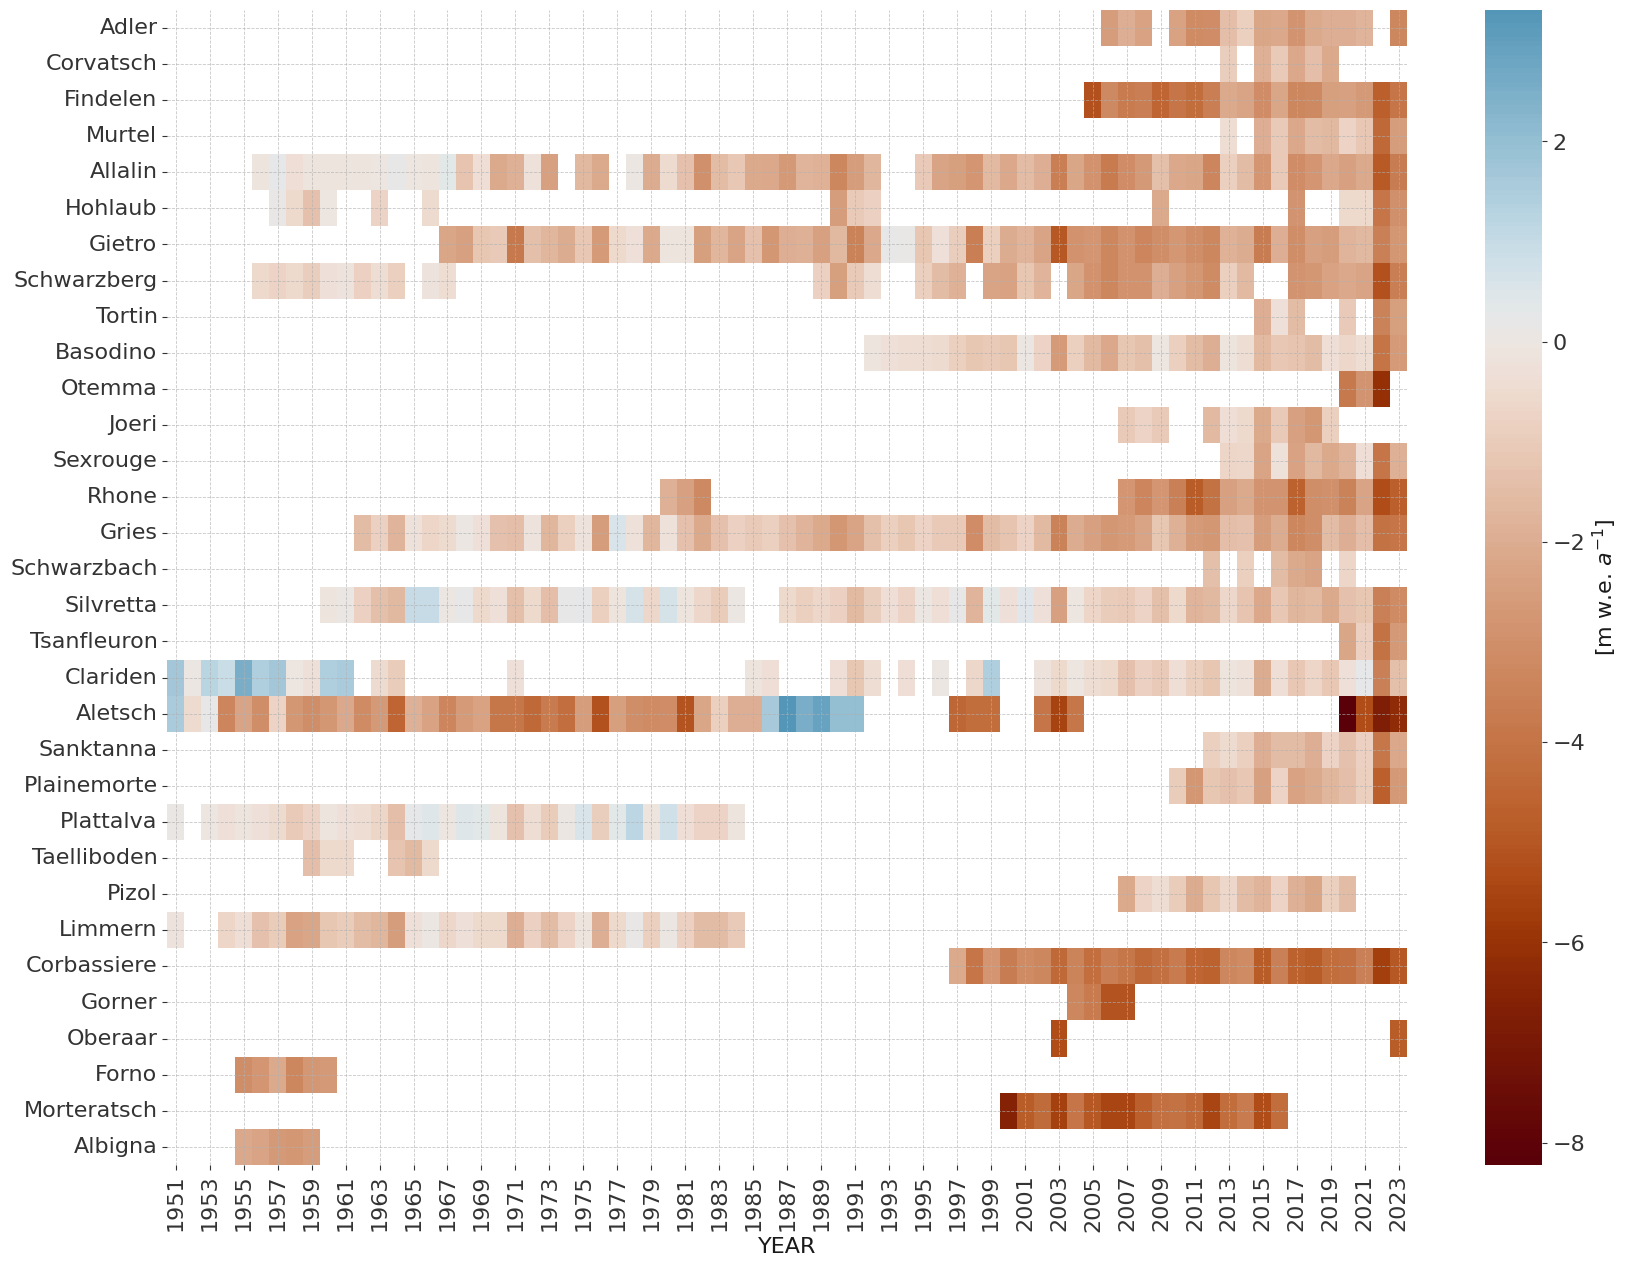

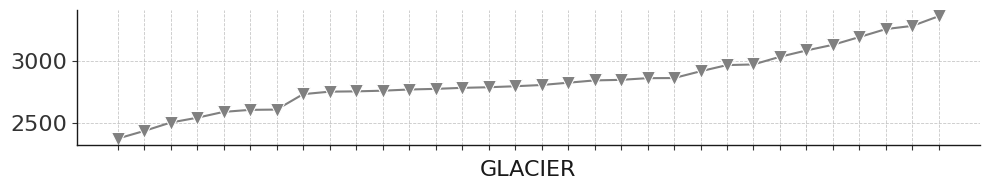

In [8]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos['GLACIER'].apply(lambda x: glacierCap[x])

mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()


## Input data:
### Input dataset:

In [9]:
RUN = False

print('Number of annual and seasonal samples: ', len(data_glamos))

if RUN:
    # Takes about 3 minutes to run
    # Filter data_glamos
    print('Running on {} glaciers:\n {}'.format(
        len(data_glamos.GLACIER.unique()), data_glamos.GLACIER.unique()))
    # Create dataloader:
    dataset_gl = mbm.Dataset(data=data_glamos,
                             region_name='CH',
                             data_path=path_PMB_GLAMOS_csv)
    print('Number of winter and annual samples:', len(data_glamos))
    print('Number of annual samples:',
          len(data_glamos[data_glamos.PERIOD == 'annual']))
    print('Number of winter samples:',
          len(data_glamos[data_glamos.PERIOD == 'winter']))

    # Add climate data:
    # Specify the files of the climate data, that will be matched with the coordinates of the stake data
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

    # Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
    dataset_gl.get_climate_features(climate_data=era5_climate_data,
                                    geopotential_data=geopotential_data,
                                    change_units=True)

    # Add potential clear sky radiation:
    print('----------------------\nAdding potential clear sky radiation:')
    print('Shape before pot rad:', dataset_gl.data.shape)
    dataset_gl.get_potential_rad(path_direct_save)
    print('Shape after pot rad:', dataset_gl.data.shape)

    print('----------------------\nConverting to monthly resolution:')
    # For each record, convert to a monthly time resolution
    dataset_gl.convert_to_monthly(meta_data_columns=config.META_DATA,
                                  vois_climate=vois_climate + ['pcsr'],
                                  vois_topographical=vois_topographical)

    # Create a new DataLoader object with the monthly stake data measurements.
    dataloader_gl = mbm.DataLoader(data=dataset_gl.data,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)

    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Columns in the dataset:', dataloader_gl.data.columns)

    # save the data
    dataloader_gl.data.to_csv(path_PMB_GLAMOS_csv +
                              'CH_wgms_dataset_monthly_full.csv',
                              index=False)
    data_monthly = dataloader_gl.data
else:
    # read data
    data_monthly = pd.read_csv(path_PMB_GLAMOS_csv +
                               'CH_wgms_dataset_monthly_full.csv')
    dataloader_gl = mbm.DataLoader(data=data_monthly,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)
    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Number of annual rows:',
          len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
    print('Number of winter rows:',
          len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))


Number of annual and seasonal samples:  33405
Number of monthly rows: 295500
Number of annual rows: 100043
Number of winter rows: 195457


### Correction for elevation difference:

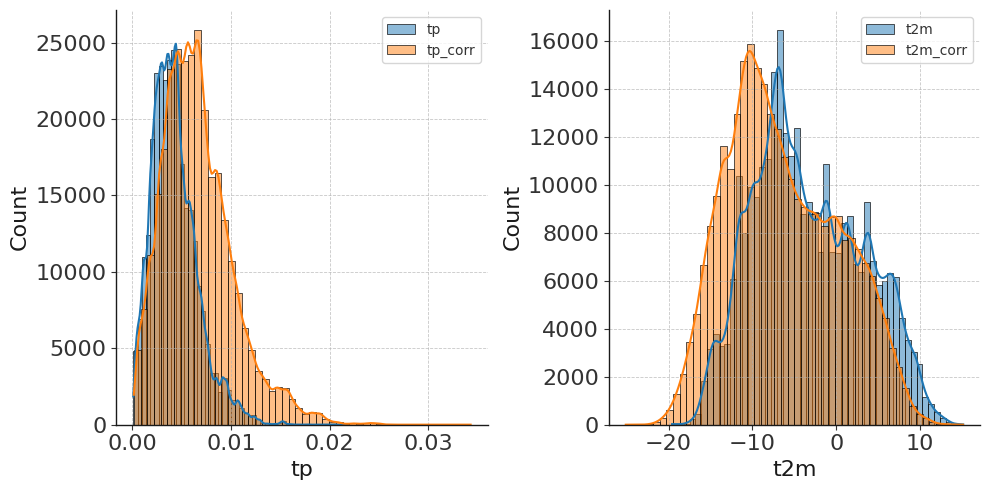

In [10]:
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors = glogem_factors.rename(columns={'ID': 'RGIId'})
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation(gl_specific=False)

# Plot the distribution of the corrected precipitation:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=ax)
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=ax)
ax.legend()

ax = plt.subplot(1, 2, 2)
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=ax)
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=ax)
ax.legend()

plt.tight_layout()

### Feature correlation:

<Axes: >

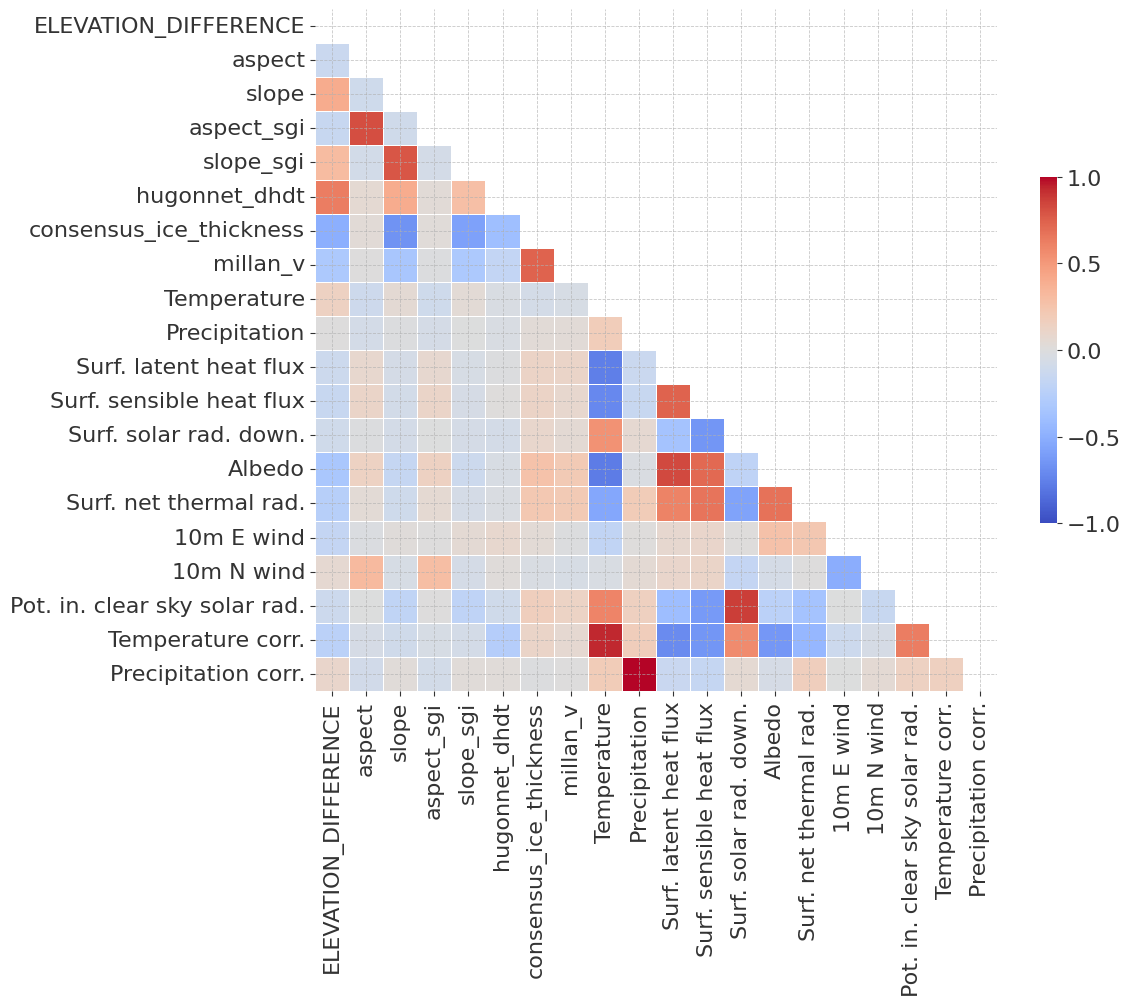

In [11]:
# Intercorrelation between features:
df = dataloader_gl.data.copy()
df = df.dropna()
df = df.drop(columns=[
    'GLACIER',
    'PERIOD',
    'YEAR',
    'POINT_LON',
    'POINT_LAT',
    'POINT_BALANCE',
    'ALTITUDE_CLIMATE',
    'POINT_ELEVATION',
    'RGIId',
    'POINT_ID',
    'ID',
    'N_MONTHS',
    'MONTHS',
])
# rename voi climate to long name
df.rename(columns=vois_climate_long_name, inplace=True)

corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# plot
sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Num. meas per year:

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

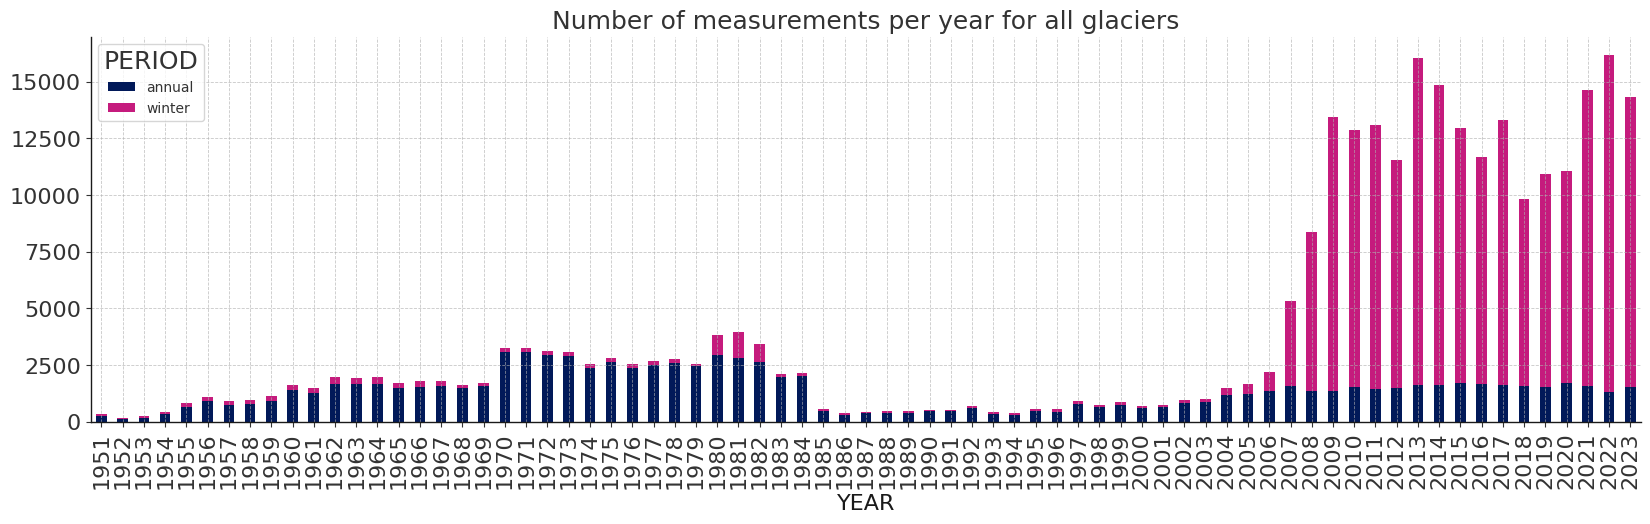

In [12]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

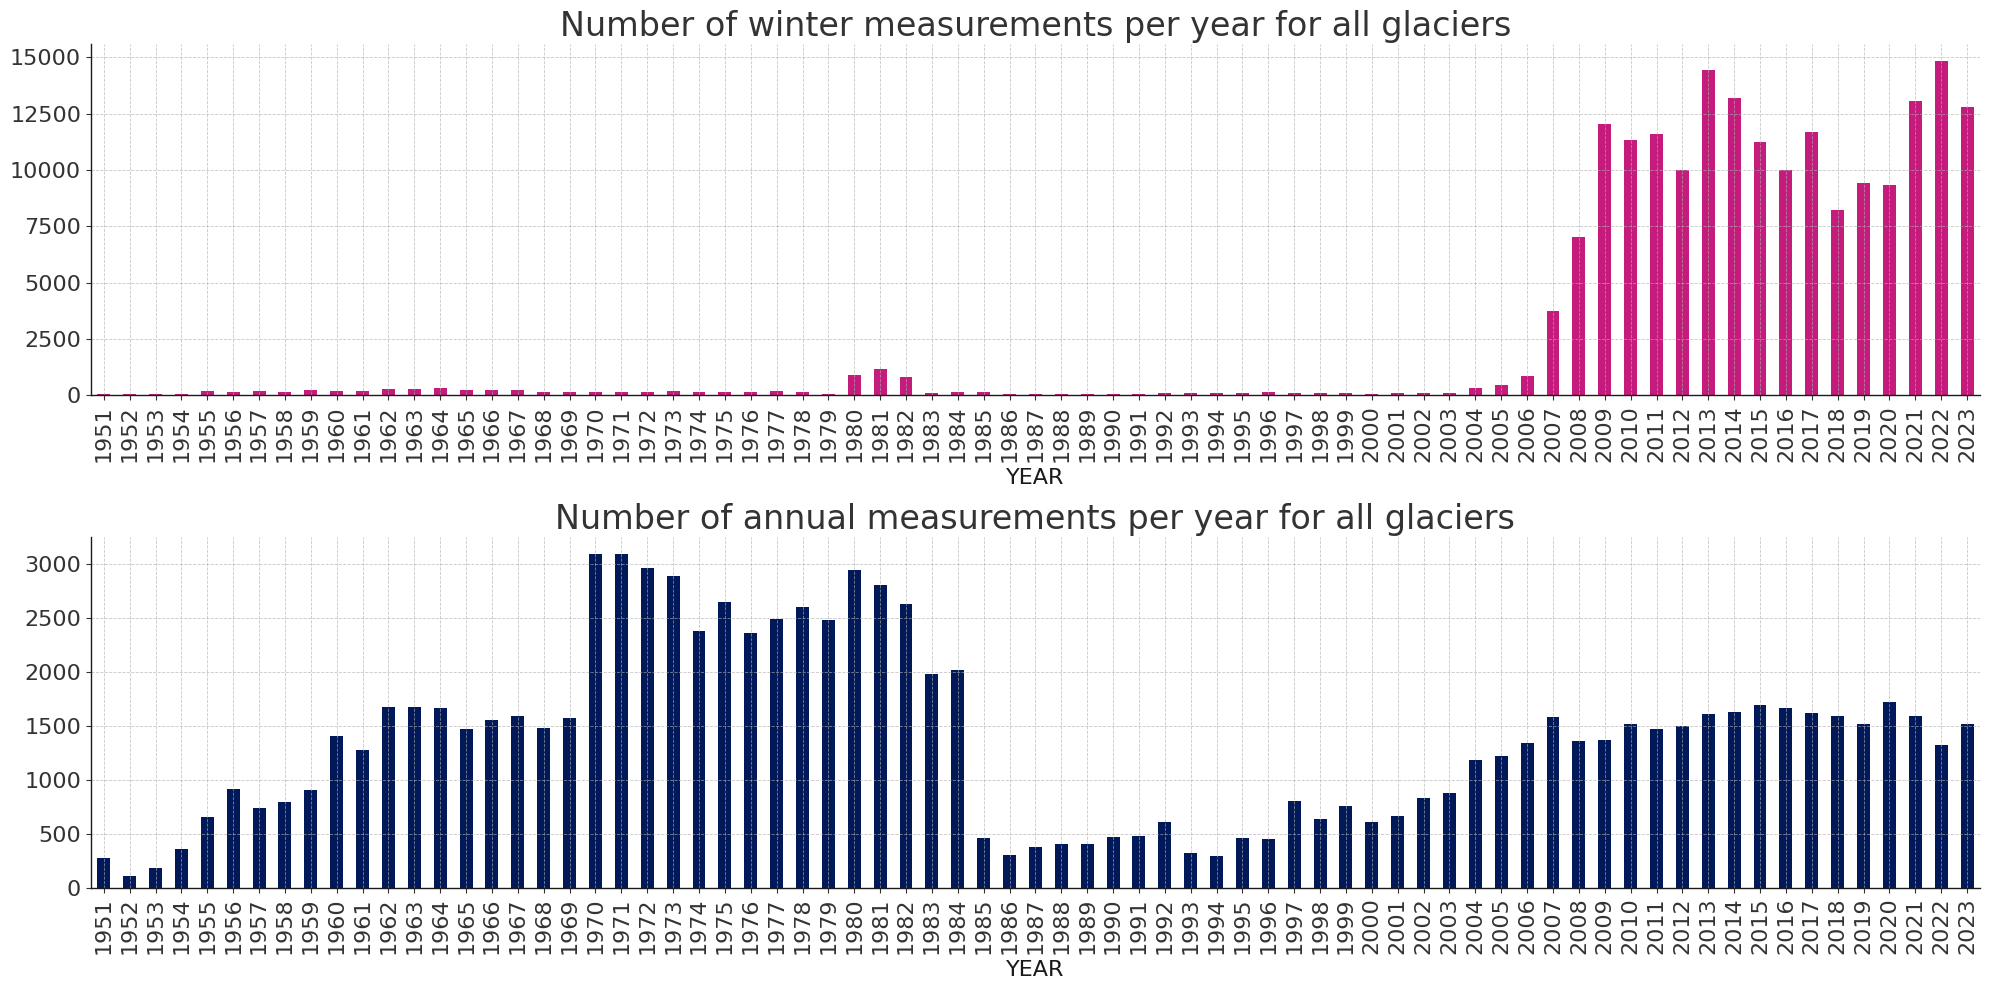

In [13]:
# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Sanity checks:

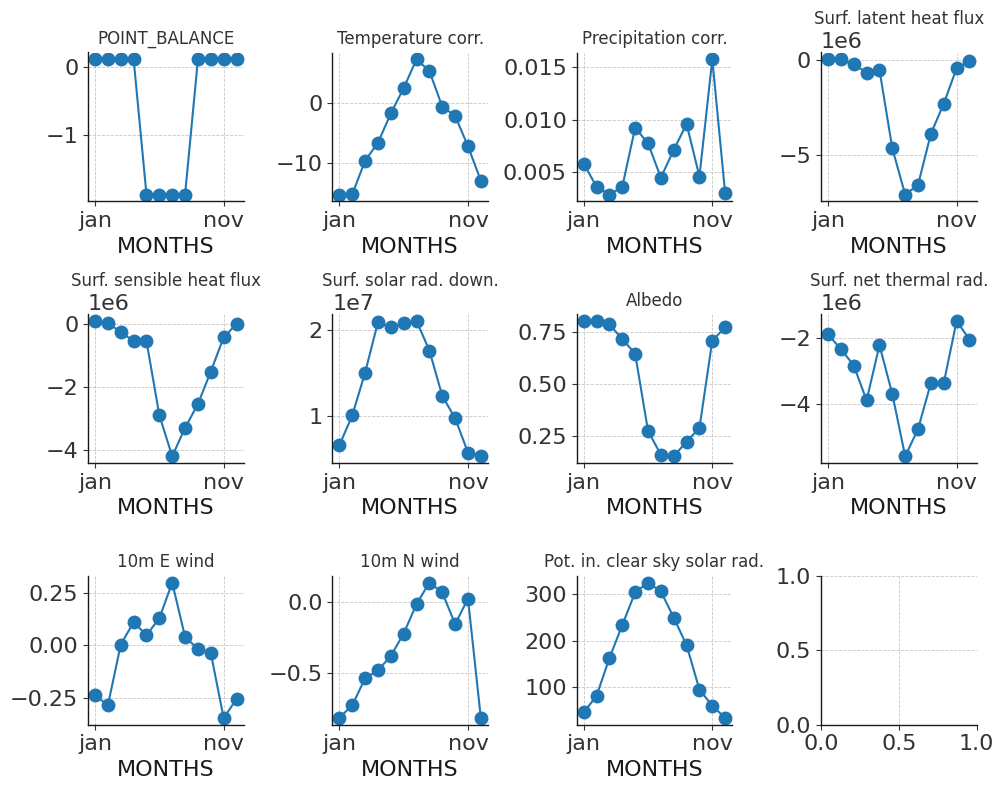

In [14]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

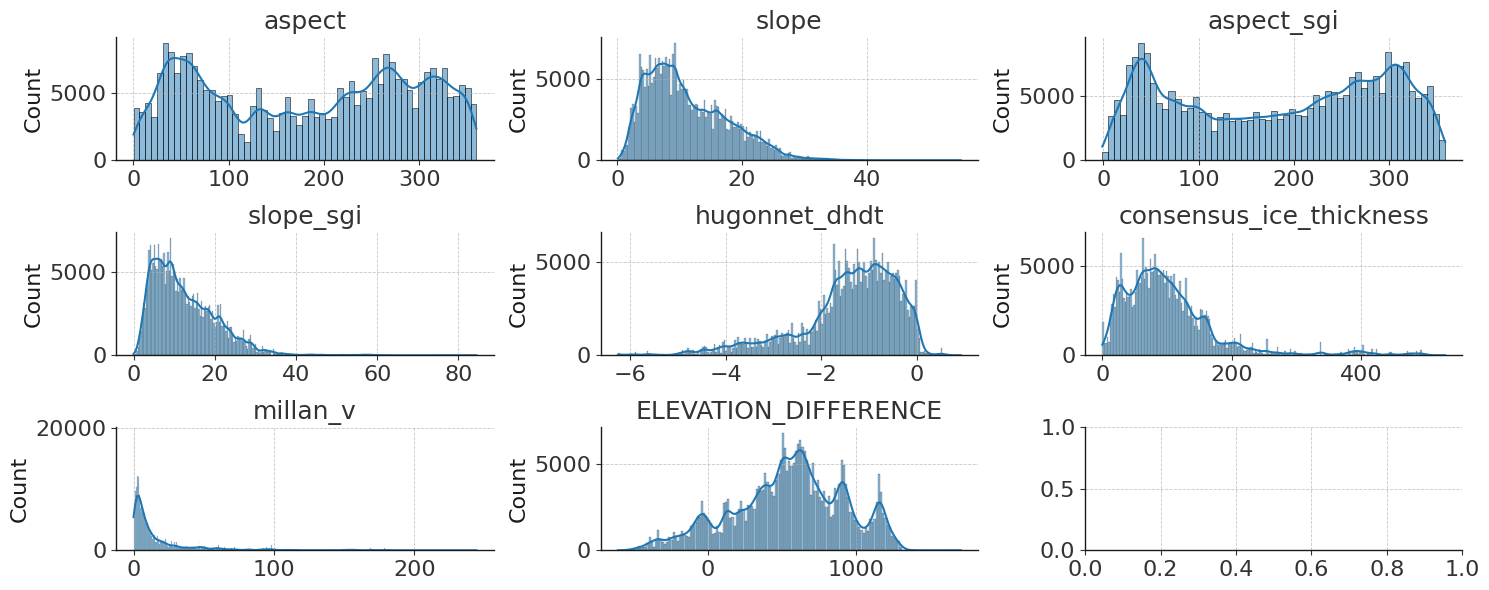

In [15]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:

In [16]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'joeri', 'corvatsch', 'tsanfleuron'
]
train_glaciers = [
    i for i in dataloader_gl.data.GLACIER.unique() if i not in test_glaciers
]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

test_perc = (len(data_test) / len(data_train)) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))

Size of test data: 32974
Size of train data: 262526
Percentage of test size: 12.56%


In [17]:
# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:',
      len(data_test[data_test.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_test[data_test.PERIOD == 'winter']))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Train:
Number of winter and annual samples: 262526
Number of annual samples: 91123
Number of winter samples: 171403
Test:
Number of winter and annual samples: 32974
Number of annual samples: 8920
Number of winter samples: 24054
Total:
Number of monthly rows: 295500
Number of annual rows: 100043
Number of winter rows: 195457


#### Heatmap annual:

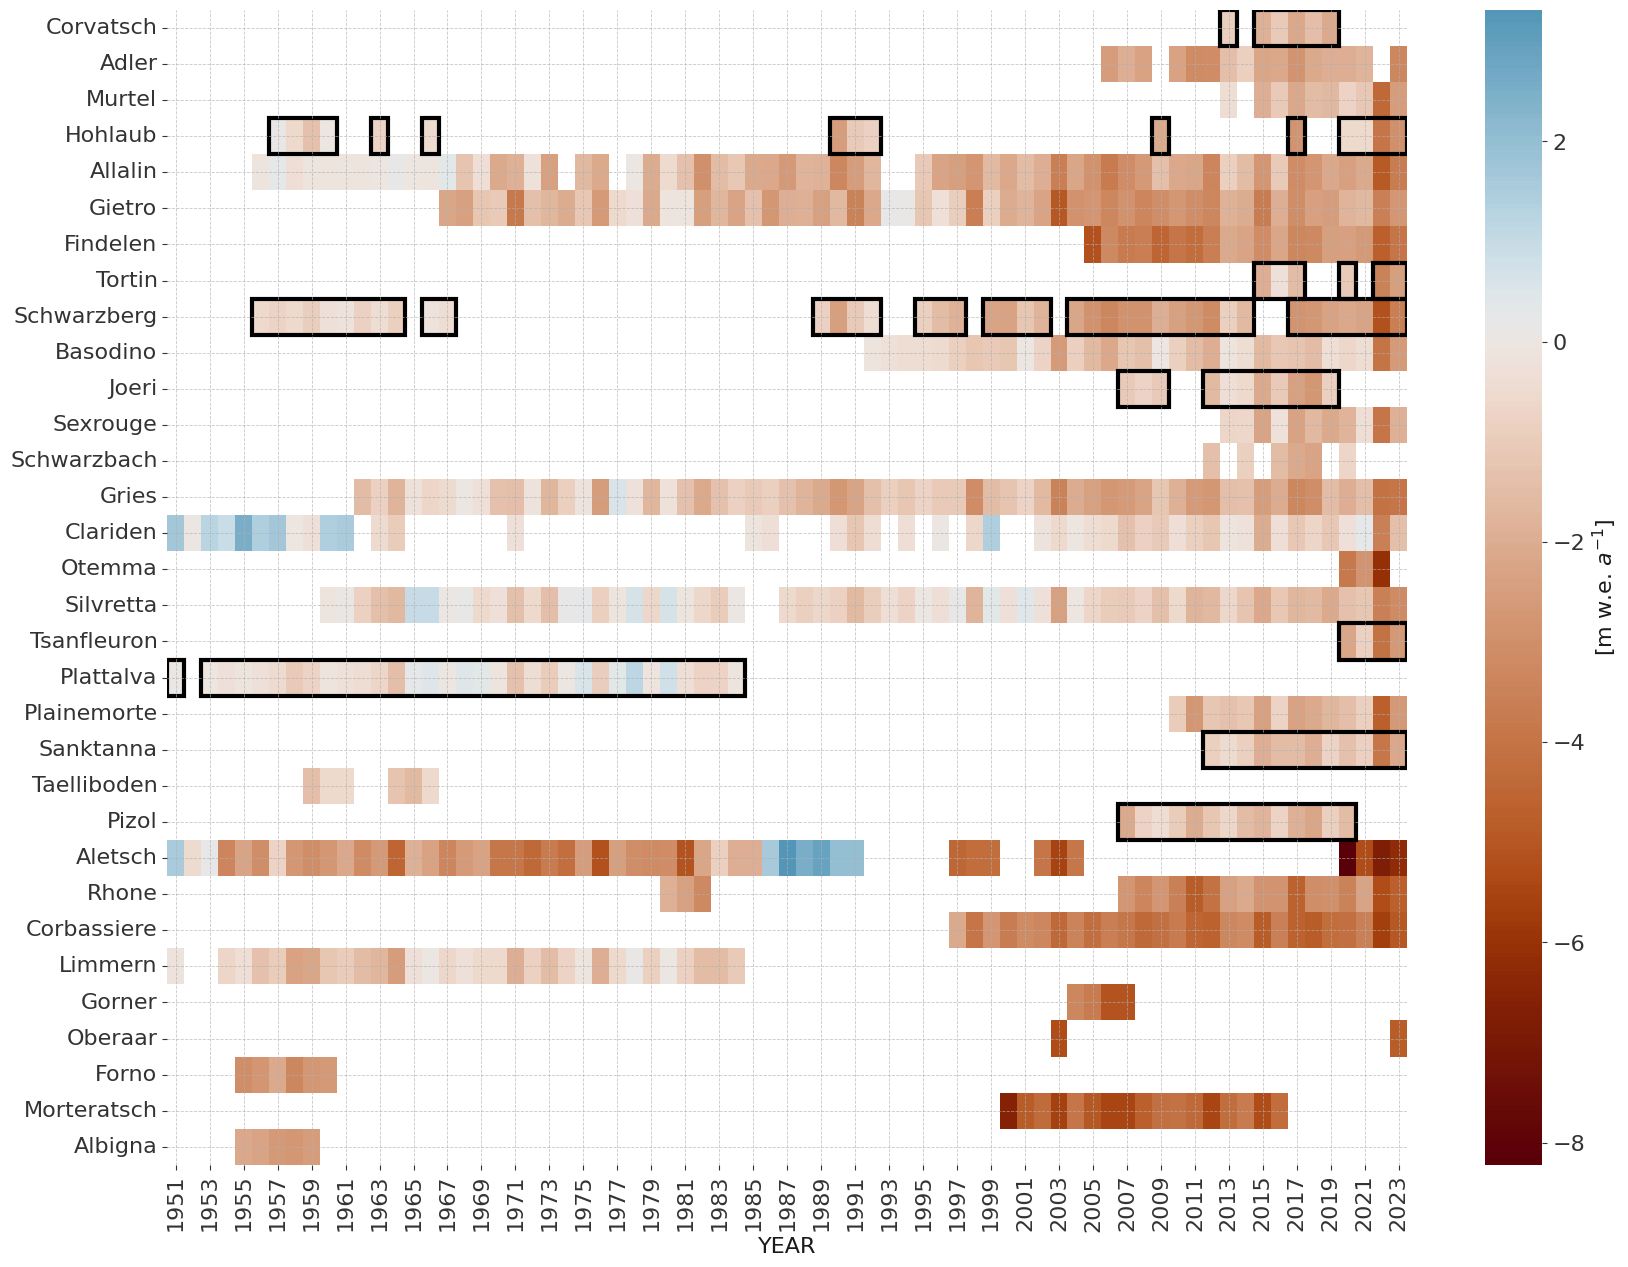

In [18]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='annual')

#### Heatmap winter:

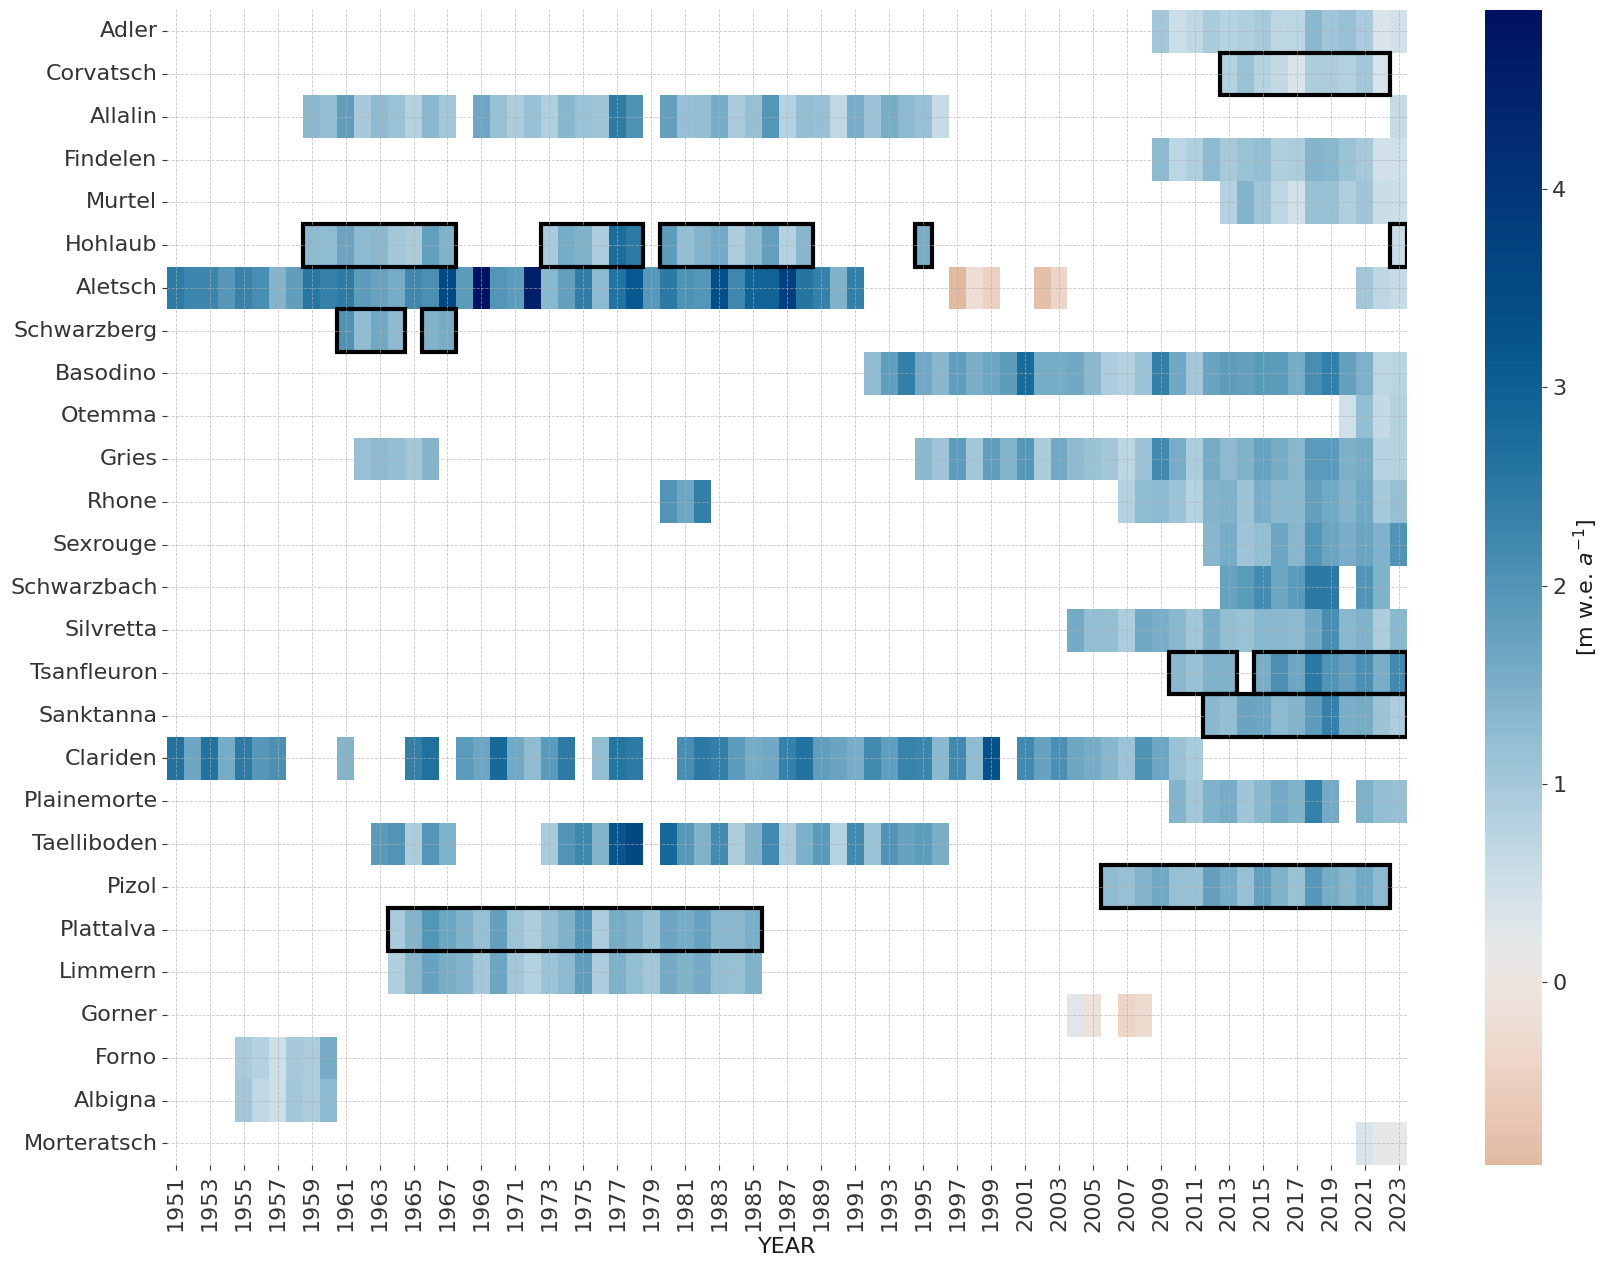

In [19]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='winter')

#### CV splits:

Test glaciers: (9) ['corvatsch' 'hohlaub' 'joeri' 'pizol' 'plattalva' 'sanktanna'
 'schwarzberg' 'tortin' 'tsanfleuron']
Percentage of test size: 12.56%
Size of test set: 32974
Train glaciers: (23) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'clariden' 'corbassiere'
 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'limmern' 'morteratsch'
 'murtel' 'oberaar' 'otemma' 'plainemorte' 'rhone' 'schwarzbach'
 'sexrouge' 'silvretta' 'taelliboden']
Size of train set: 262526


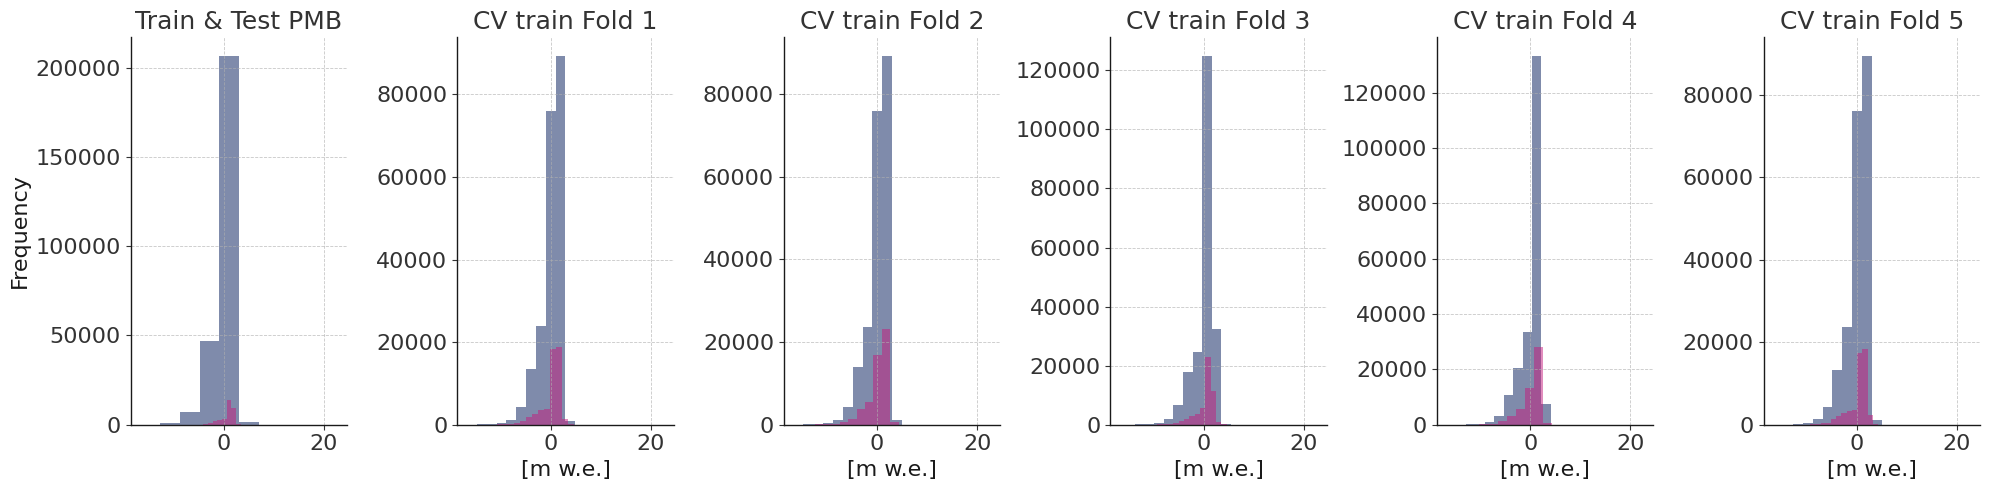

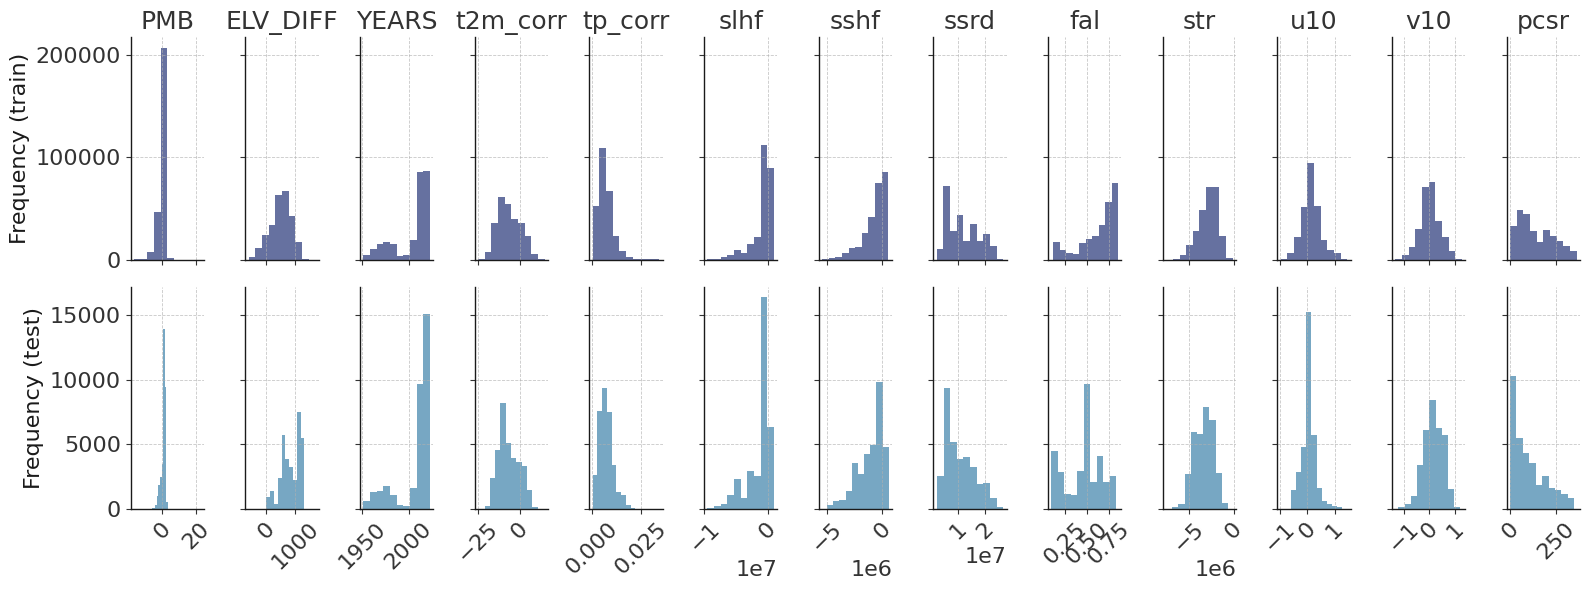

In [20]:
splits, test_set, train_set = getCVSplits(dataloader_gl,
                                          test_split_on='GLACIER',
                                          test_splits=test_glaciers)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))
visualiseSplits(test_set['y'], train_set['y'], splits)

visualiseInputs(train_set, test_set, vois_climate)


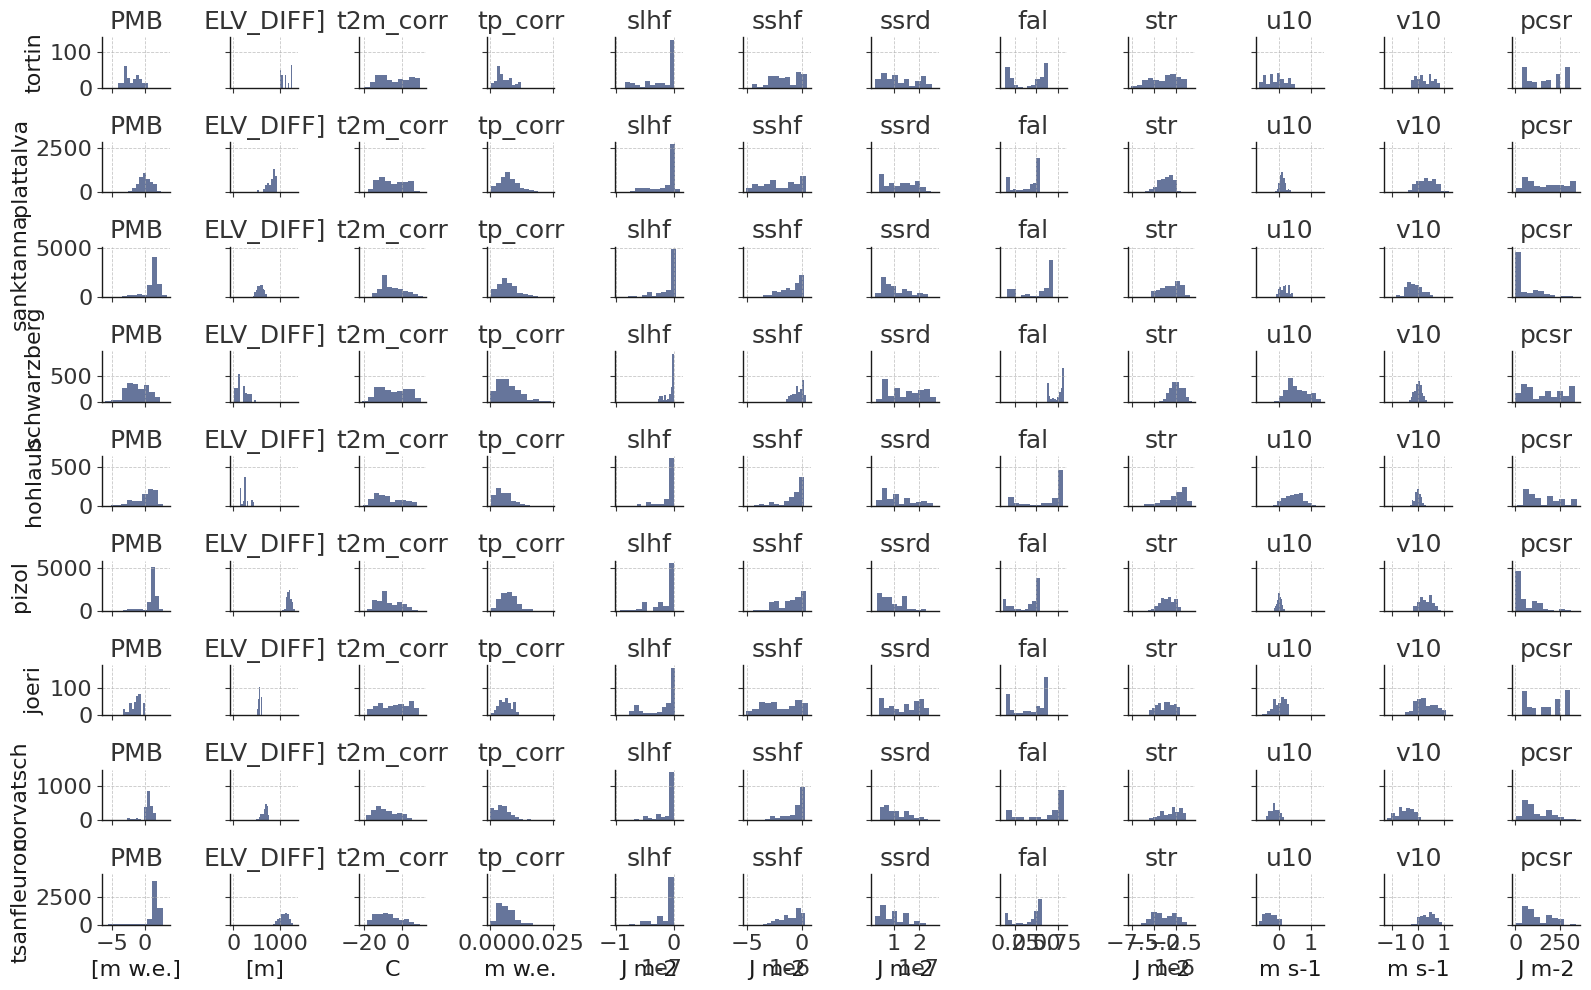

In [21]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

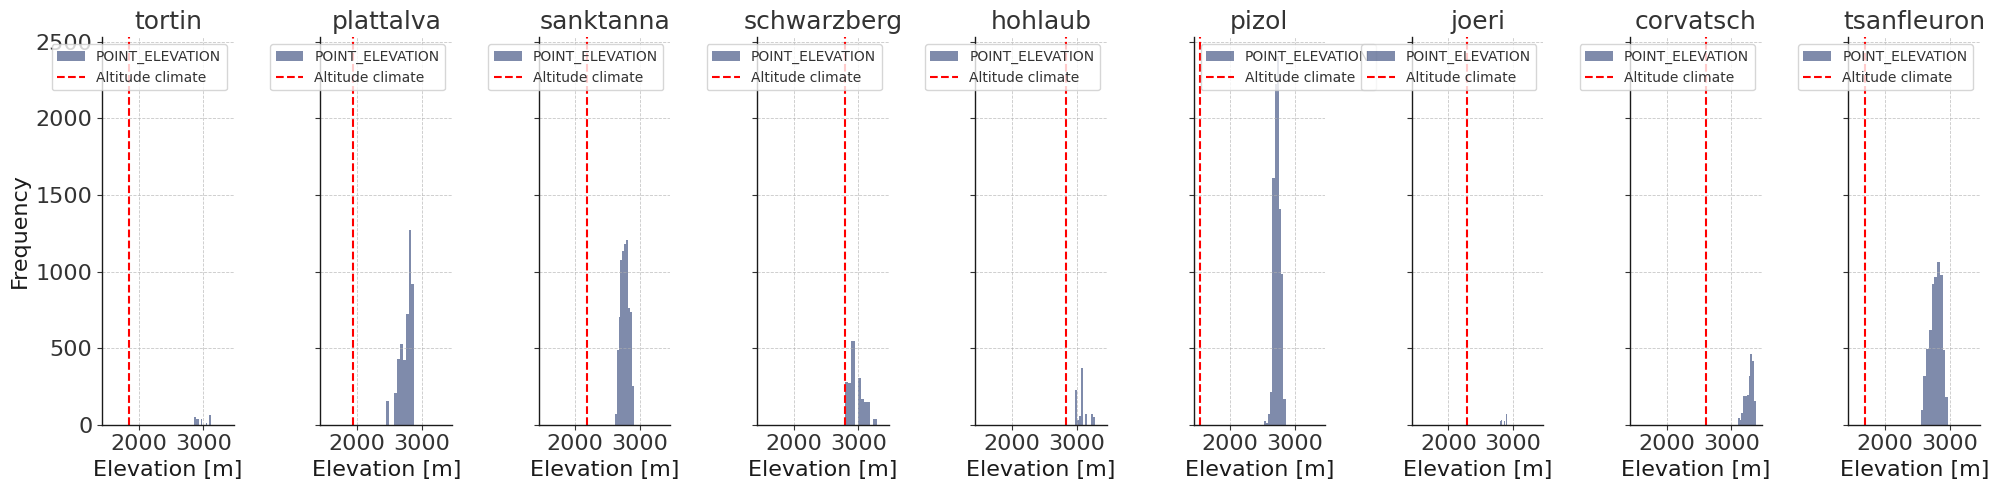

In [22]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

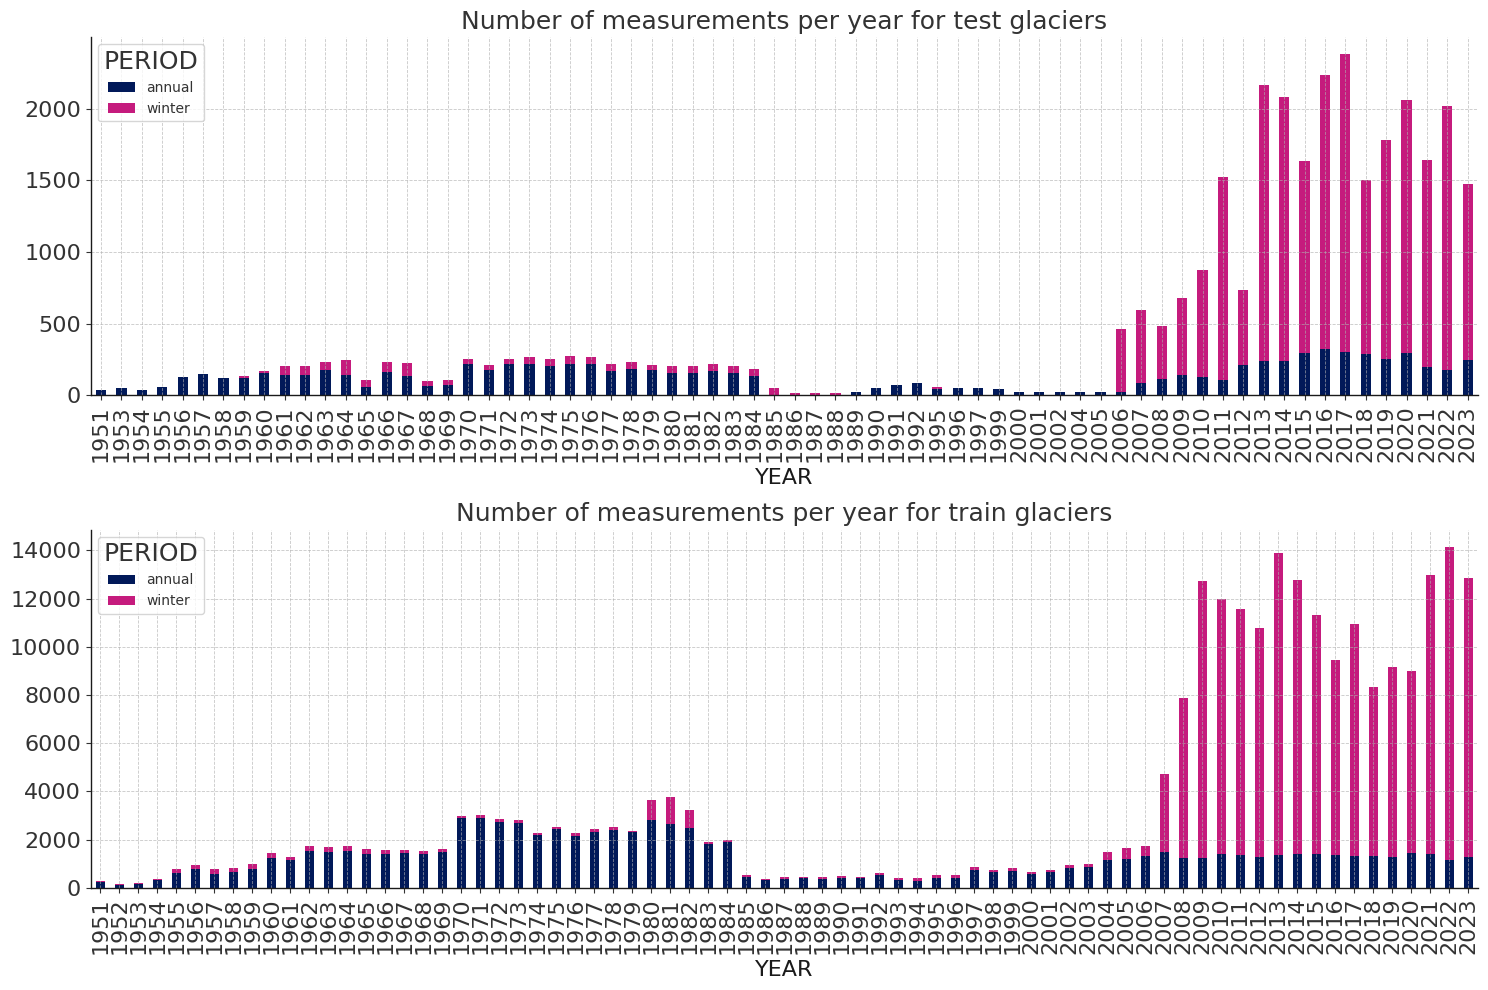

In [23]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

### Grid search:

In [24]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = config.SEED
param_init["n_jobs"] = config.NUM_JOBS

CORRECTED_VARS = True
if CORRECTED_VARS:
    vois_climate = [
        't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
        'v10'
    ]
else:
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [25]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(**param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # custom_xgboost.gridsearch(
    #     parameters=param_grid,
    #     splits=splits,
    #     features=df_X_train_subset,
    #     targets=train_set['y'],
    # )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_sgi_corr.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor()
    custom_xgboost.load_model(
        f'xgb_gl_split_sgi_corr.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))


Shape of training dataset: (262526, 27)
Shape of testing dataset: (32974, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.22374252662373392
Shape of the test: (32974, 16)
Overall score: 0.47384498691393023
CPU times: user 3.56 s, sys: 74.6 ms, total: 3.63 s
Wall time: 337 ms


In [26]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

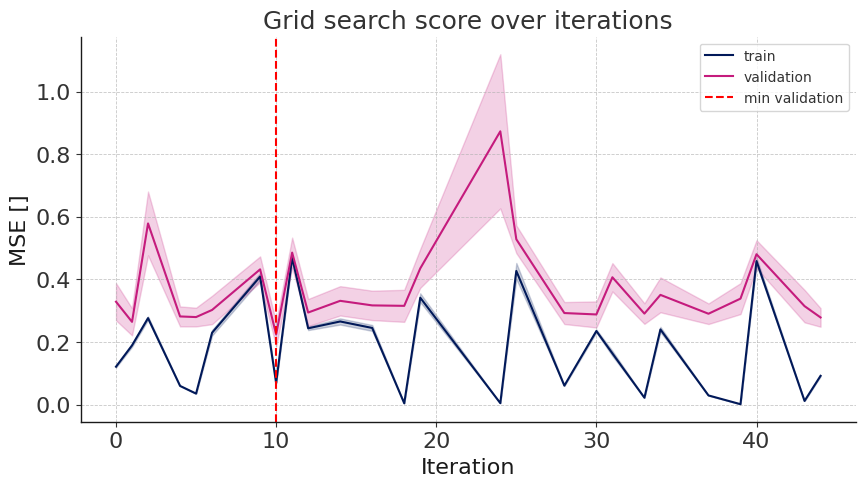

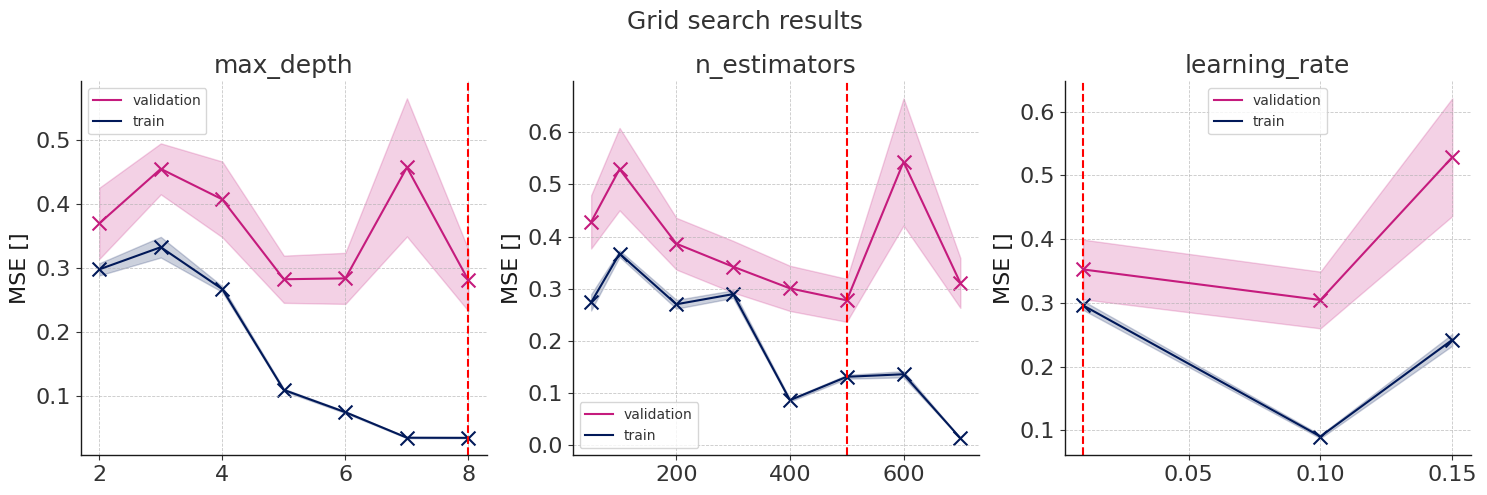

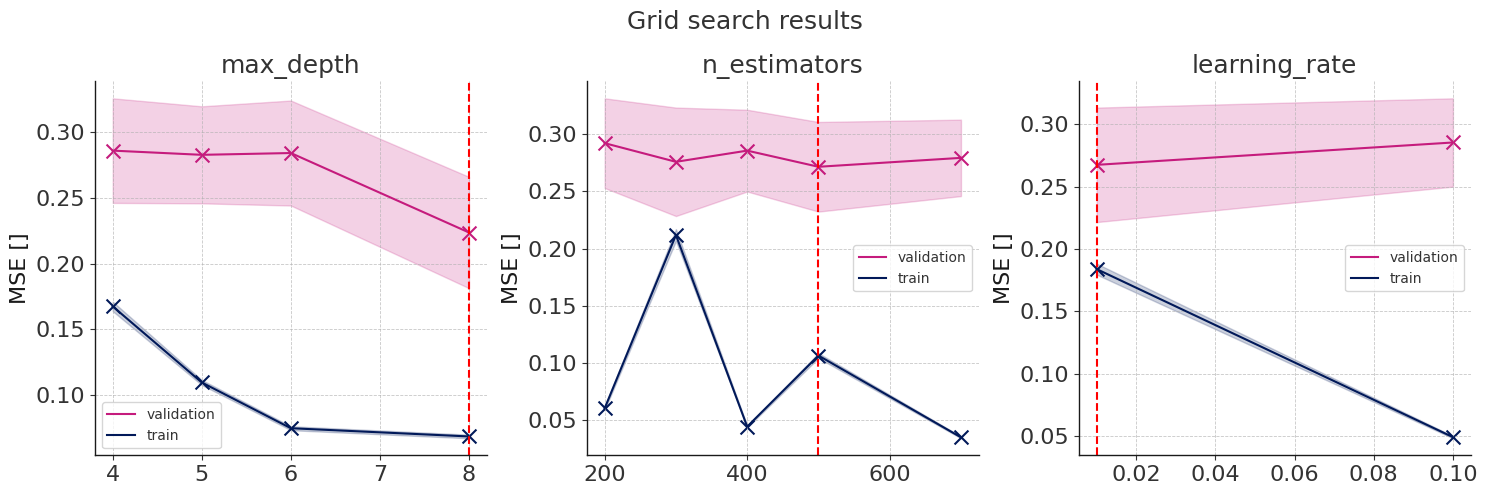

In [27]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, N=10)

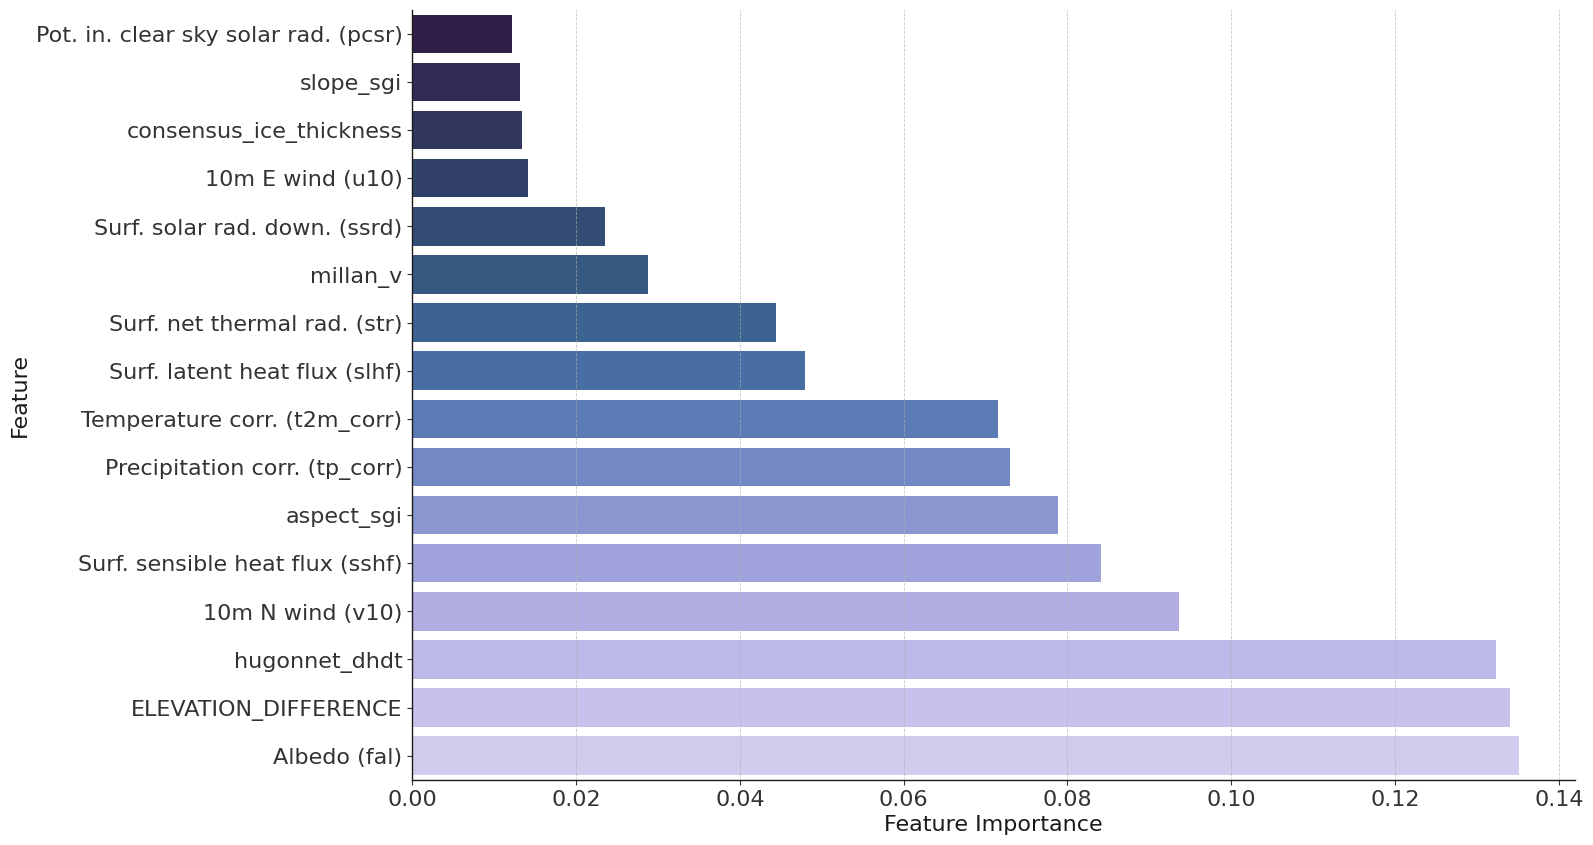

In [28]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (32974, 16)
{'corvatsch': '#a6cee3', 'hohlaub': '#1f78b4', 'joeri': '#b2df8a', 'pizol': '#33a02c', 'plattalva': '#fb9a99', 'sanktanna': '#e31a1c', 'schwarzberg': '#fdbf6f', 'tortin': '#ff7f00', 'tsanfleuron': '#cab2d6'}


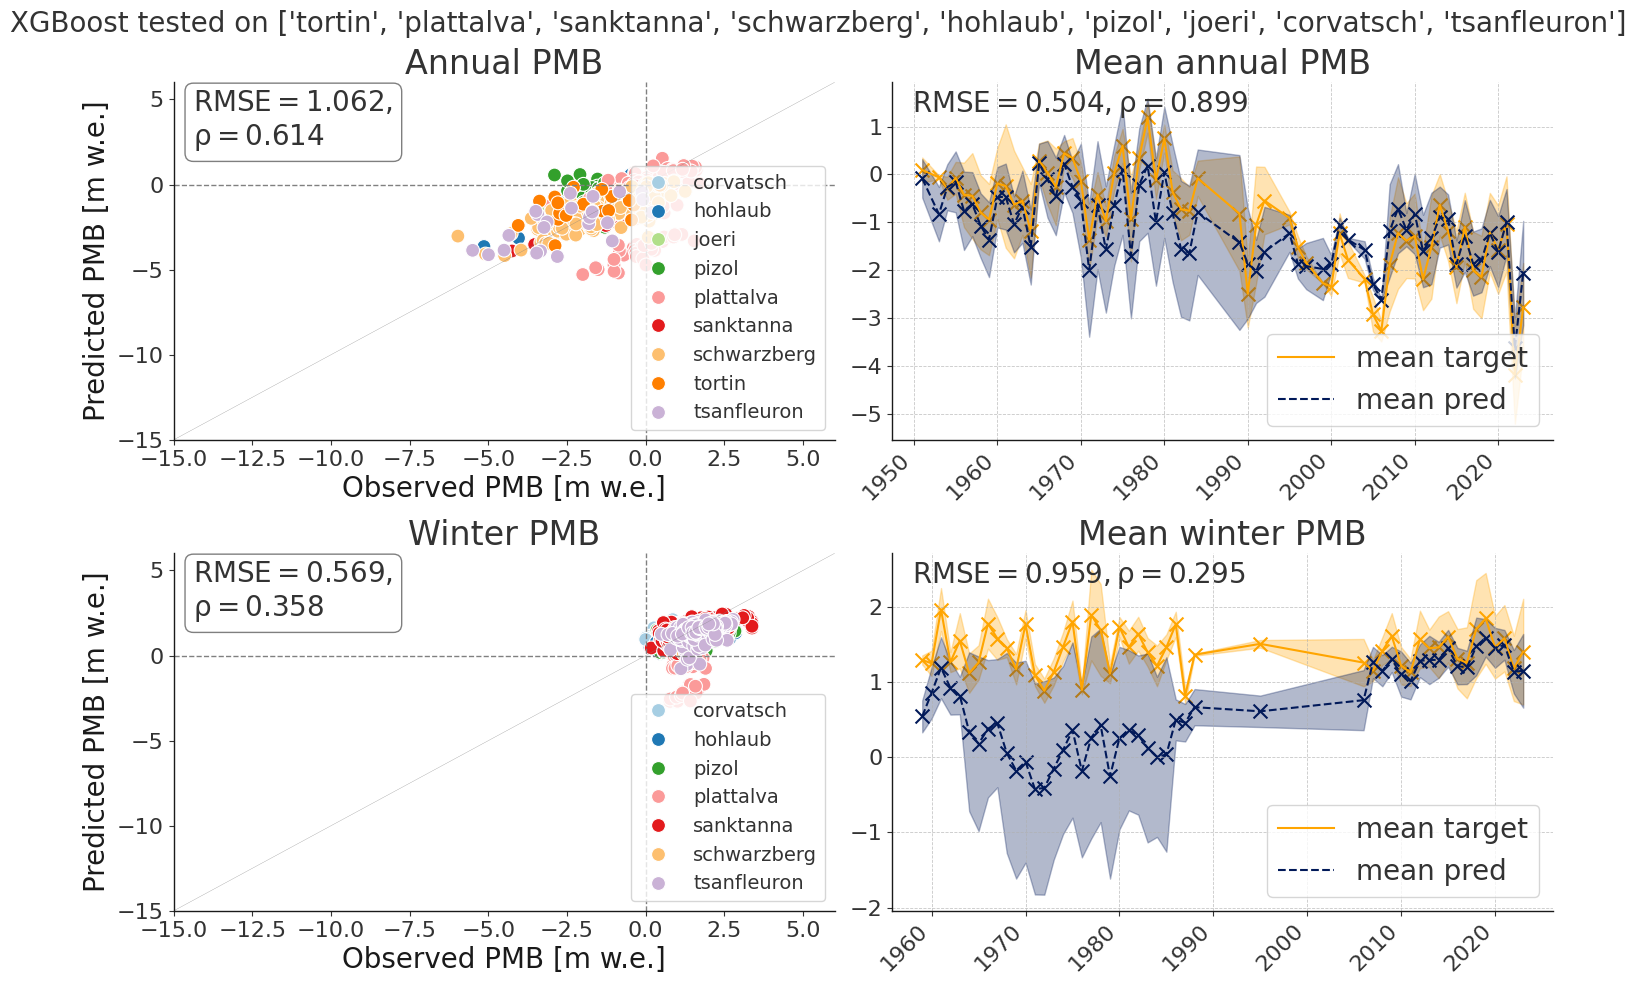

In [29]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()


### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(**params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA,
                                      features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

Shape of training dataset: (262526, 27)
Shape of testing dataset: (32974, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect_sgi', 'slope_sgi', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 'pcsr']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': 25, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}


In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Cumulative MB:

In [ ]:
df_metadata = pd.DataFrame(metadata_test, columns=config.META_DATA)
df_metadata = df_metadata.assign(y_pred=y_pred)

# separate into annual and winter
dfpred_annual = df_metadata[df_metadata['PERIOD'] == 'annual']
dfpred_winter = df_metadata[df_metadata['PERIOD'] == 'winter']

# plot distribution of predictions per month, one plot per month
f, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
for i, month in enumerate(month_abbr[1:]):
    dfpred_annual[dfpred_annual['MONTHS'] == month.lower()].y_pred.plot.hist(
        ax=ax.flatten()[i],
        color=color_annual,
        alpha=0.6,
        density=False,
        label='annual')
    if month.lower() in dfpred_winter.MONTHS.unique():
        dfpred_winter[dfpred_winter['MONTHS'] ==
                      month.lower()].y_pred.plot.hist(ax=ax.flatten()[i],
                                                      color=color_winter,
                                                      alpha=0.6,
                                                      density=False,
                                                      label='winter')
    ax.flatten()[i].set_title(month, fontsize=24)
    ax.flatten()[i].set_xlabel('[m w.e.]', fontsize=20)
    ax.flatten()[i].legend(fontsize=16)
    # add vertical line for 0 balance
    ax.flatten()[i].axvline(x=0, color='black', linestyle='--')
plt.tight_layout()

In [ ]:
# group ID to YEAR
ids_year_dict = test_set['df_X'][[
    'ID', 'YEAR'
]].groupby('ID')['YEAR'].unique().apply(list).to_dict()
ids_year_dict = {
    k: v[0] if len(v) == 1 else v
    for k, v in ids_year_dict.items()
}

In [ ]:
# Plot mean and std
fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    dfCumMB_all = cumulativeMB(dfpred_annual, test_gl, ids_year_dict)

    meanMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.mean()).reset_index()
    stdMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.std()).reset_index()

    meanMB['monthNb'] = meanMB['months'].apply(
        lambda x: month_abbr_hydr_full[x])
    stdMB['monthNb'] = stdMB['months'].apply(lambda x: month_abbr_hydr_full[x])
    # sort both by their monthNB
    meanMB = meanMB.sort_values(by='monthNb')
    stdMB = stdMB.sort_values(by='monthNb')

    ax = axs.flatten()[i]
    ax.plot(meanMB['months'].values, meanMB['cum_MB'], color='black')
    ax.fill_between(meanMB['months'].values,
                    meanMB['cum_MB'] - stdMB['cum_MB'],
                    meanMB['cum_MB'] + stdMB['cum_MB'],
                    color=color_dark_blue,
                    alpha=0.2)
    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')
    # add horizontal line for 0 balance
    ax.axhline(y=0, color='black', linestyle='--')
    # rotate xticks
    ax.set_xticklabels(meanMB.months, rotation=45)
plt.tight_layout()

In [ ]:
cmap = plt.cm.plasma_r

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    ax = axs.flatten()[i]

    dfCumMB = cumulativeMB(dfpred_annual, test_gl, ids_year_dict)

    norm = plt.Normalize(dfCumMB['year'].min(), dfCumMB['year'].max())

    for year in dfCumMB['year'].unique():
        dfCumMB_year = dfCumMB[dfCumMB.year == year]

        meanMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.mean()).reset_index()
        stdMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.std()).reset_index()

        meanMB['monthNb'] = meanMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        stdMB['monthNb'] = stdMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        # sort both by their monthNB
        meanMB = meanMB.sort_values(by='monthNb')
        stdMB = stdMB.sort_values(by='monthNb')

        color = cmap(norm(year))
        ax.plot(meanMB['months'], meanMB['cum_MB'], color=color, label=year)
        ax.fill_between(meanMB['months'],
                        meanMB['cum_MB'] - stdMB['cum_MB'],
                        meanMB['cum_MB'] + stdMB['cum_MB'],
                        color=color,
                        alpha=0.2)

    # rotate xticks
    ax.set_xticklabels(month_abbr_hydr_full.keys(), rotation=45)

    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for colorbar to work
    cbar = fig.colorbar(
        sm, ax=ax)  # Attach the colorbar to the figure and the specific axis
    cbar.set_label('Year')

plt.tight_layout()

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()
years_end_per_gl


In [ ]:
periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

# Plot an example
# Plot geodetic MB of silvretta for all periods
glacierName = 'silvretta'
periods = periods_per_glacier[glacierName]
geoMB = geoMB_per_glacier[glacierName]

fig, ax = plt.subplots(figsize=(10, 5))
for i, period in enumerate(periods):
    ax.plot(period, [geoMB[i], geoMB[i]], label=f'Period {i+1}')
ax.set_title(f'Geodetic MB of {glacierName.capitalize()}')

### Glacier wide MB: 
Compute 2D fields to compare wtih years that have Sentinel data.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

glacier_list = list(data_glamos.GLACIER.unique())

print('Number of glaciers:', len(glacier_list))
glacier_list.sort()

In [ ]:
def find_processed_and_incomplete_glaciers(folder_path, all_glaciers):
    """
    Identifies glaciers that are fully processed and those with missing years.

    Parameters:
        folder_path (str): Path to the folder containing the files.
        all_glaciers (list): List of all glaciers that need to be processed.

    Returns:
        tuple: A list of fully processed glaciers and a dictionary of incomplete glaciers with missing years.
    """
    processed_years = defaultdict(set)

    # Regular expression to match the filename format
    pattern = re.compile(
        r'^(?P<glacier>[a-zA-Z_]+)_grid_(?P<year>\d{4})\.csv$')

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            glacier = match.group('glacier')
            year = int(match.group('year'))
            if 2000 <= year <= 2023:
                processed_years[glacier].add(year)

    fully_processed = []
    incomplete_glaciers = {}

    # Check for completeness for each glacier
    for glacier in all_glaciers:
        all_years = set(range(2000, 2023))
        if glacier in processed_years:
            missing_years = all_years - processed_years[glacier]
            if not missing_years:
                fully_processed.append(glacier)
            else:
                incomplete_glaciers[glacier] = sorted(missing_years)
        else:
            incomplete_glaciers[glacier] = sorted(all_years)

    return fully_processed, incomplete_glaciers


fully_processed, incomplete_glaciers = find_processed_and_incomplete_glaciers(
    path_glacier_grid_sgi, glacier_list)
fully_processed, incomplete_glaciers

In [ ]:
# One example
path_save = 'results/nc/sgi_corr/'

satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()

# join the two lists and remove duplicates
all_glaciers = list(set(satellite_glaciers + list(geodetic_glaciers)))

# keep only glaciers that have a computed SGI grid
all_glaciers = [gl for gl in all_glaciers if gl in fully_processed]
all_glaciers.sort()

EMPTY = False
if EMPTY:
    emptyfolder(path_save)
    remaining_gl = all_glaciers
else:
    already_processed = os.listdir(path_save)
    remaining_gl = Diff(already_processed, all_glaciers)
    remaining_gl.sort()

remaining_gl

In [ ]:
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES

print('Running for features columns:', all_columns)

for glacierName in tqdm(remaining_gl, desc='Glaciers'):
    print(glacierName)
    for year in tqdm(range(2000, 2024), desc='Years', leave=False):
        df_grid_monthly = pd.read_csv(path_glacier_grid_sgi +
                                      f'{glacierName}_grid_{year}.csv')

        # apply T & P correction
        # Apply temperature gradient correction
        temp_grad = -6.5 / 1000
        dpdz = 1.5 / 10000
        c_prec = 1.434,
        t_off = 0.617
        df_grid_monthly['t2m_corr'] = df_grid_monthly['t2m'] + (
            df_grid_monthly['ELEVATION_DIFFERENCE'] * temp_grad)
        df_grid_monthly['tp_corr'] = df_grid_monthly['tp'] * c_prec
        df_grid_monthly['t2m_corr'] += t_off
        
        # Apply elevation correction factor
        df_grid_monthly['tp_corr'] += df_grid_monthly['tp_corr'] * (df_grid_monthly['ELEVATION_DIFFERENCE'] * dpdz)

        # Rename aspect and slope to sgi
        df_grid_monthly.rename(columns={
            'aspect': 'aspect_sgi',
            'slope': 'slope_sgi'
        },
                               inplace=True)
        df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
        df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
        df_grid_monthly = df_grid_monthly[all_columns]

        # Add cumulative monthly SMB:
        df_grid_monthly = custom_model.cumulative_pred(df_grid_monthly)

        # Seasonal predictions:
        grouped_ids_annual = GlacierWidePred(custom_model,
                                             df_grid_monthly[all_columns],
                                             type_pred='annual')

        grouped_ids_winter = GlacierWidePred(custom_model,
                                             df_grid_monthly[all_columns],
                                             type_pred='winter')

        # Annual SMB:
        pred_y_annual = grouped_ids_annual[grouped_ids_annual.YEAR ==
                                           year].drop(['YEAR'], axis=1)
        # Winter SMB:
        pred_y_winter = grouped_ids_winter[grouped_ids_winter.YEAR ==
                                           year].drop(['YEAR'], axis=1)

        ds = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                             f'{glacierName}.nc')

        geoData = mbm.GeoData(pred_y_annual)
        geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
        filename = f"{glacierName}_{year}_annual.nc"
        geoData.save_arrays(filename,
                            path=path_save + f"{glacierName}/",
                            proj_type='wgs84')

        geoData = mbm.GeoData(pred_y_winter)
        geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
        filename = f"{glacierName}_{year}_winter.nc"
        geoData.save_arrays(filename,
                            path=path_save + f"{glacierName}/",
                            proj_type='wgs84')

        # Save monthly grids:
        for i, month in enumerate(config.month_abbr_hydr.keys()):
            # Only do spring and summer months because otherwise no satelitte data
            if month in ['sep_', 'oct', 'nov', 'dec', 'jan', 'feb']:
                continue
            monthNb = config.month_abbr_hydr[month]
            df_grid_gl_m = df_grid_monthly[df_grid_monthly['MONTHS'] == month]

            # Get in format for map:
            df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
                'YEAR': 'mean',
                'POINT_LAT': 'mean',
                'POINT_LON': 'mean',
                'pred': 'mean',
                'cum_pred': 'mean'
            })
            pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
            geoData = mbm.GeoData(pred_y)
            geoData.pred_to_xr(ds, pred_var='cum_pred', source_type='sgi')
            filename = f"{glacierName}_{year}_{monthNb}.nc"
            geoData.save_arrays(filename,
                                path=path_save + f"{glacierName}/",
                                proj_type='wgs84')

In [ ]:
# open xarray
xr.open_dataset(path_save + 'aletsch/aletsch_2023_annual.nc').pred_masked.plot()